# Group 5
## Team members:
- Jianting Liu(8950907)
- David (8999846) 
- Marieth (9016702)


# Canadian Housing Market Analysis: 20-Year Review

## Use Case Summary & Hypothesis Testing

The analysis examines the relationship between housing prices, income, and population in Canada over a 20-year period. By incorporating population data alongside existing housing prices and income metrics, we can better understand the demographic pressures on housing affordability.

### Hypothesis

**Null Hypothesis (H0):**  
There is no significant correlation between population growth and housing price increases when controlling for income changes.

**Alternative Hypothesis (H1):**  
Population growth has a significant positive correlation with housing price increases, even after controlling for income changes.

This enhanced analysis will help determine whether population growth is a significant driver of housing prices beyond what can be explained by income changes alone.


Megeing data

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

class IncomeDataProcessor:
    """
    A class to process income and house price data.
    """

    def __init__(self, income_data_path, original_data_path):
        """
        Initializes the class with the given data paths.

        Args:
            income_data_path (str): Path to the income data CSV file.
            original_data_path (str): Path to the original data Excel file.
        """
        self.income_data = pd.read_csv(income_data_path)
        self.original_data = pd.read_excel(original_data_path)

    def clean_data(self):
        """
        Cleans the income data by removing currency symbols and converting to numeric.
        """
        self.income_data['Median income'] = self.income_data['Median income'].str.replace('$', '').str.replace(',', '').astype(float)

    def convert_to_monthly(self):
        """
        Converts annual income to monthly income and creates a new DataFrame.
        """
        new_rows = []
        
        for index, row in self.income_data.iterrows():
            year = row["Reference year"]
            median_income = row["Median income"] / 12  # Convert to monthly income
            
            for month in range(1, 13):
                date_str = f"{year}-{month:02d}-01"
                date = pd.to_datetime(date_str, format='%Y-%m-%d')
                
                new_row = {
                    "Date": date,
                    "Median income": median_income,
                    "Count of families": row["Count of families"],
                    "Family type": row["Family type"],
                    "Geography": row["Geography"],
                    "Selected income concept": row["Selected income concept"]
                }
                new_rows.append(new_row)
        
        self.monthly_data = pd.DataFrame(new_rows)
        
        return self.monthly_data

    def merge_data(self):
        """
        Merges the income data with the original data based on the 'Date' column.
        """
        self.monthly_data['Date'] = pd.to_datetime(self.monthly_data['Date'], format='%Y-%m-%d')
        self.merged_data = pd.merge(self.original_data, self.monthly_data[['Date', 'Median income']], on='Date', how='left')
        # Filter data from 2005 to 2022
        self.merged_data = self.merged_data[(self.merged_data['Date'].dt.year >= 2005) & 
                                           (self.merged_data['Date'].dt.year <= 2022)]
        return self.merged_data
    
    def apply_kmeans_clustering(self, n_clusters=3):
        """
        Applies K-Means clustering on 'Median income' and 'Apartment_unit' columns.
        
        Args:
            n_clusters (int): Number of clusters to form.
        
        Returns:
            DataFrame with a new 'Cluster' column.
        """
        clustering_data = self.merged_data[['Median income', 'Apartment_unit']].dropna()
        
        # Data scaling
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(clustering_data)

        # K-Means clustering
        kmeans = KMeans(n_clusters=n_clusters, random_state=0)
        clustering_data['Cluster'] = kmeans.fit_predict(scaled_data)
        
        # Plot clusters
        plt.figure(figsize=(10, 6))
        sns.scatterplot(
            x='Median income', y='Apartment_unit', 
            hue='Cluster', data=clustering_data, palette='viridis'
        )
        plt.title("Clustering of Income and Apartment Prices")
        plt.show()

        return clustering_data

    def save_data(self, output_path):
        """
        Saves the merged data to a CSV file.
        """
        self.merged_data.to_csv(output_path)
    
    def exploratory_data_analysis(self):
        """
        Performs exploratory data analysis, including:
            - Visualizing the relationship between income and house price
            - Histogram and box plot of income and apartment prices
        """

        # Histogramas de Median income y Apartment_unit
        plt.figure(figsize=(10, 10))

        # Histogram of Median income
        plt.subplot(2, 1, 1)
        sns.histplot(self.merged_data['Median income'].dropna(), kde=True)
        plt.title("Distribution of Median Income")

        # Histogram of Apartment_unit prices
        plt.subplot(2, 1, 2)
        sns.histplot(self.merged_data['Apartment_unit'].dropna(), kde=True)
        plt.title("Distribution of Apartment Prices")

        plt.tight_layout()
        plt.show()

        # Boxplots de Median income y Apartment_unit
        plt.figure(figsize=(10, 10))

        # Box plot of Median income
        plt.subplot(2, 1, 1)
        sns.boxplot(x=self.merged_data['Median income'].dropna())
        plt.title("Box Plot of Median Income")

        # Box plot of Apartment_unit prices
        plt.subplot(2, 1, 2)
        sns.boxplot(x=self.merged_data['Apartment_unit'].dropna())
        plt.title("Box Plot of Apartment Prices")

        plt.tight_layout()
        plt.show()

        # Scatter plot of income vs apartment prices
        sns.scatterplot(x='Median income', y='Apartment_unit', data=self.merged_data)
        plt.title("Income vs Apartment Prices")
        plt.show()


# Example usage
processor = IncomeDataProcessor('incomedata.csv', 'News_release_chart_data_August_2024.xlsx')
processor.clean_data()
processor.convert_to_monthly()
data = processor.merge_data()



We download the population data from the website and convert it to monthly data.
data source:https://www150.statcan.gc.ca/t1/tbl1/en/tv.action?pid=1710000901&cubeTimeFrame.startMonth=01&cubeTimeFrame.startYear=2005&cubeTimeFrame.endMonth=07&cubeTimeFrame.endYear=2024&referencePeriods=20050101%2C20240701

In [14]:
def convert_excel_format(input_file, output_file, merge_file):
    # Read Excel file
    df = pd.read_excel(input_file)
    
    # Get column names and data values
    dates = df.columns.tolist()[1:]  # Skip first column
    values = df.iloc[0, 1:].tolist()  # Skip first column
    
    # Create new DataFrame
    new_df = pd.DataFrame({
        'Date': dates,
        'Population': values
    })
    
    # Remove rows containing 'Date' or 'Population'
    new_df = new_df[~new_df['Date'].isin(['Date'])]
    
    # Convert quarterly data to date format
    new_df['Date'] = new_df['Date'].str.replace('Q', '').str.split().apply(
        lambda x: pd.to_datetime(f"{x[1]}-{int(x[0])*3-2}-01")
    )
    
    # Create empty lists for monthly data
    monthly_dates = []
    monthly_populations = []
    
    # Process each quarterly data
    for idx, row in new_df.iterrows():
        quarter_start = row['Date']
        population = row['Population']
        
        # Create data for three months in each quarter
        for month in range(3):
            monthly_date = quarter_start + pd.DateOffset(months=month)
            monthly_population = population / 3  # Distribute quarterly population evenly across months
            
            monthly_dates.append(monthly_date)
            monthly_populations.append(monthly_population)
    
    # Create new monthly DataFrame
    monthly_df = pd.DataFrame({
        'Date': monthly_dates,
        'Population': monthly_populations
    })
    
    # Sort by date
    monthly_df = monthly_df.sort_values('Date').reset_index(drop=True)
    
    # Format date column to 'YYYY-MM-DD'
    monthly_df['Date'] = monthly_df['Date'].dt.strftime('%Y-%m-%d')
    
    # Read CSV file to merge
    merge_df = pd.read_csv(merge_file)
    
    # Ensure Date columns have consistent format in both DataFrames
    merge_df['Date'] = pd.to_datetime(merge_df['Date']).dt.strftime('%Y-%m-%d')
    
    # Merge data
    final_df = pd.merge(merge_df, monthly_df, on='Date', how='left')
    
    # Save final result
    final_df.to_excel(output_file, index=False)
    
    return final_df

# Usage example
input_file = 'population.xlsx'
merge_file = 'mergeddata.csv'
output_file = 'final_merged_data.xlsx'

result = convert_excel_format(input_file, output_file, merge_file)
print(result.head())

         Date  Composite  One_storey  Two_storey  Townhouse  Apartment_unit  \
0  2005-01-01     239800      207700      302900     201700          172000   
1  2005-02-01     240500      208400      303300     202300          173000   
2  2005-03-01     241300      209200      304300     202900          173900   
3  2005-04-01     242000      210100      304800     203300          174600   
4  2005-05-01     242600      210600      305400     203700          175400   

   Median income    Population  
0         4487.5  1.069167e+07  
1         4487.5  1.069167e+07  
2         4487.5  1.069167e+07  
3         4487.5  1.071352e+07  
4         4487.5  1.071352e+07  


### Get all data

In [15]:
data = pd.read_excel('final_merged_data.xlsx')
data.head()


,Date,Composite,One_storey,Two_storey,Townhouse,Apartment_unit,Median income,Population
0,2005-01-01,239800,207700,302900,201700,172000,4487.5,1.069167e+07
1,2005-02-01,240500,208400,303300,202300,173000,4487.5,1.069167e+07
2,2005-03-01,241300,209200,304300,202900,173900,4487.5,1.069167e+07
3,2005-04-01,242000,210100,304800,203300,174600,4487.5,1.071352e+07
4,2005-05-01,242600,210600,305400,203700,175400,4487.5,1.071352e+07


### Perform extensive cleanup and data source preparation by applying the dimensionality reduction techniques covered in class.
- Missing Values Ratio
- Low Variance Filter
- High Correlation Filter
- Principal Components Analysis
- Random Forest Trees
- Backward/Forward Feature Elimination/Selection

1. Missing Values Analysis:
                Missing Count  Missing Percentage
Date                        0                 0.0
Composite                   0                 0.0
One_storey                  0                 0.0
Two_storey                  0                 0.0
Townhouse                   0                 0.0
Apartment_unit              0                 0.0
Median income               0                 0.0
Population                  0                 0.0


2. Low Variance Features:
Index([], dtype='object')




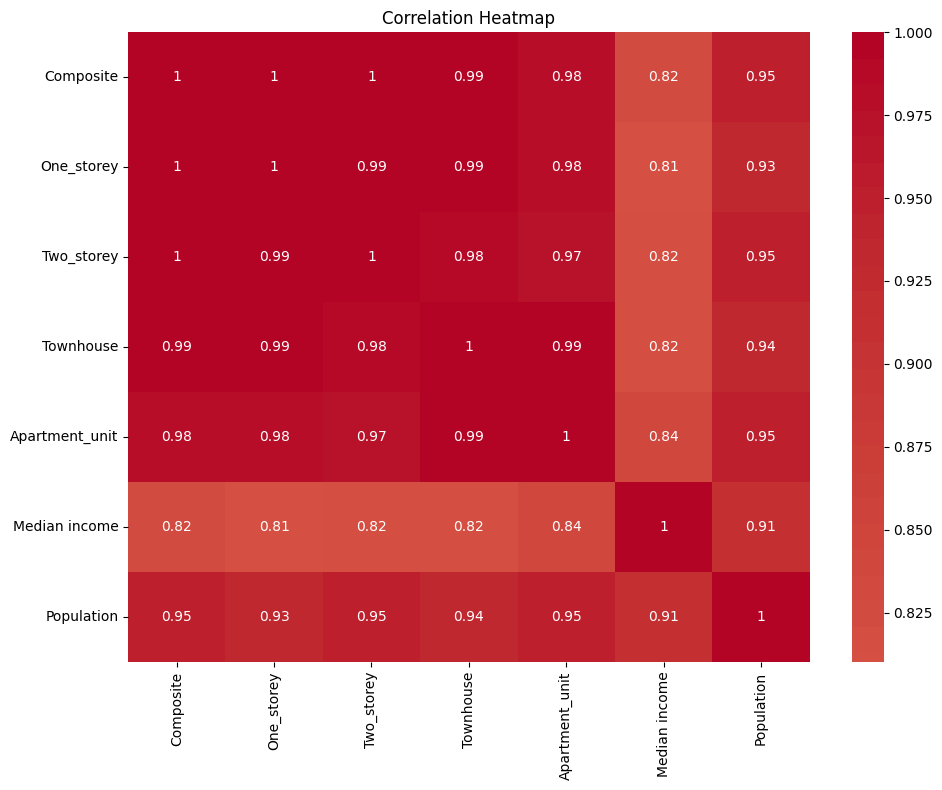

3. High Correlation Pairs:
One_storey - Composite: 0.997
Two_storey - Composite: 0.999
Two_storey - One_storey: 0.994
Townhouse - Composite: 0.992
Townhouse - One_storey: 0.994
Townhouse - Two_storey: 0.985
Apartment_unit - Composite: 0.983
Apartment_unit - One_storey: 0.979
Apartment_unit - Two_storey: 0.974
Apartment_unit - Townhouse: 0.993
Median income - Composite: 0.824
Median income - One_storey: 0.810
Median income - Two_storey: 0.819
Median income - Townhouse: 0.817
Median income - Apartment_unit: 0.841
Population - Composite: 0.947
Population - One_storey: 0.930
Population - Two_storey: 0.946
Population - Townhouse: 0.936
Population - Apartment_unit: 0.953
Population - Median income: 0.912




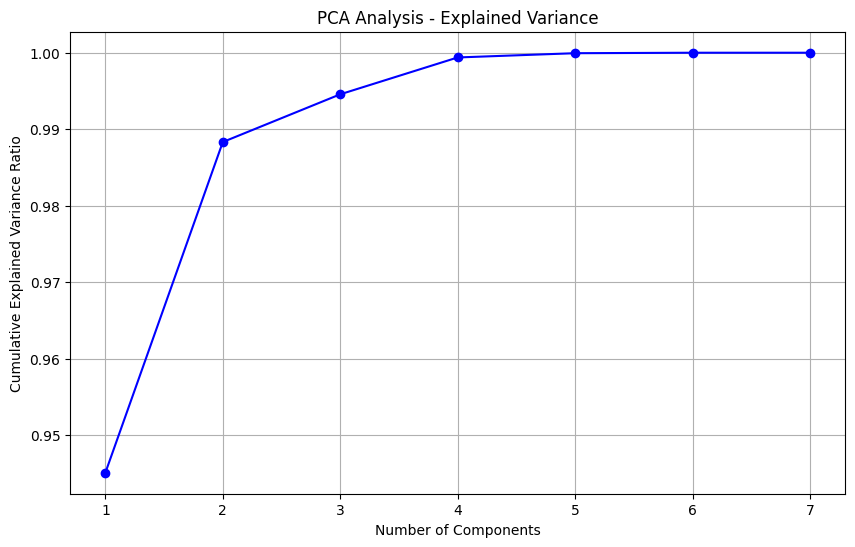

4. PCA Analysis - Explained Variance Ratio:
Component 1: 0.945
Component 2: 0.043
Component 3: 0.006
Component 4: 0.005
Component 5: 0.001
Component 6: 0.000
Component 7: 0.000


5. Random Forest Feature Importance:
          feature  importance
3  Apartment_unit    0.247236
0      One_storey    0.223955
2       Townhouse    0.197895
1      Two_storey    0.196514
5      Population    0.110760
4   Median income    0.023640


6. Recursive Feature Elimination Results:
          feature  selected  rank
0      One_storey      True     1
1      Two_storey      True     1
2       Townhouse      True     1
3  Apartment_unit      True     1
4   Median income      True     1
5      Population     False     2


In [16]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt

def comprehensive_feature_analysis(df, target_column='Composite'):
    results = {}
    df_processed = df.copy()
    
    # 1. Missing Values Ratio
    def analyze_missing_values(df):
        missing_values = df.isnull().sum()
        missing_percentage = (missing_values / len(df)) * 100
        missing_summary = pd.DataFrame({
            'Missing Count': missing_values,
            'Missing Percentage': missing_percentage
        })
        return missing_summary.sort_values('Missing Percentage', ascending=False)
    
    results['missing_values'] = analyze_missing_values(df)
    print("1. Missing Values Analysis:")
    print(results['missing_values'])
    print("\n" + "="*50 + "\n")

    # 2. Low Variance Filter
    def low_variance_filter(df, threshold=0.01):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        variances = df[numeric_cols].var()
        low_variance_features = variances[variances < threshold].index
        return low_variance_features
    
    low_var_features = low_variance_filter(df_processed)
    results['low_variance_features'] = low_var_features
    print("2. Low Variance Features:")
    print(low_var_features)
    print("\n" + "="*50 + "\n")

    # 3. High Correlation Filter
    def correlation_analysis(df, threshold=0.8):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        corr_matrix = df[numeric_cols].corr()
        high_corr_pairs = []
        
        for i in range(len(corr_matrix.columns)):
            for j in range(i):
                if abs(corr_matrix.iloc[i, j]) > threshold:
                    high_corr_pairs.append(
                        (corr_matrix.columns[i], 
                         corr_matrix.columns[j], 
                         corr_matrix.iloc[i, j])
                    )
        
        # Create correlation heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Correlation Heatmap')
        plt.tight_layout()
        plt.show()
        
        return high_corr_pairs
    
    high_corr = correlation_analysis(df_processed)
    results['high_correlation_pairs'] = high_corr
    print("3. High Correlation Pairs:")
    for pair in high_corr:
        print(f"{pair[0]} - {pair[1]}: {pair[2]:.3f}")
    print("\n" + "="*50 + "\n")

    # 4. Principal Components Analysis
    def pca_analysis(df):
        numeric_cols = df.select_dtypes(include=[np.number]).columns
        scaler = StandardScaler()
        scaled_data = scaler.fit_transform(df[numeric_cols])
        
        pca = PCA()
        pca_result = pca.fit_transform(scaled_data)
        
        # Calculate explained variance ratio
        explained_variance = pca.explained_variance_ratio_
        cumulative_variance = np.cumsum(explained_variance)
        
        # Plot explained variance
        plt.figure(figsize=(10, 6))
        plt.plot(range(1, len(explained_variance) + 1), cumulative_variance, 'bo-')
        plt.xlabel('Number of Components')
        plt.ylabel('Cumulative Explained Variance Ratio')
        plt.title('PCA Analysis - Explained Variance')
        plt.grid(True)
        plt.show()
        
        return explained_variance, cumulative_variance
    
    explained_var, cum_var = pca_analysis(df_processed)
    results['pca_explained_variance'] = explained_var
    print("4. PCA Analysis - Explained Variance Ratio:")
    for i, var in enumerate(explained_var):
        print(f"Component {i+1}: {var:.3f}")
    print("\n" + "="*50 + "\n")

    # 5. Random Forest Feature Importance
    def random_forest_importance(df, target_col):
        X = df.select_dtypes(include=[np.number]).drop(columns=[target_col])
        y = df[target_col]
        
        rf = RandomForestRegressor(n_estimators=100, random_state=42)
        rf.fit(X, y)
        
        feature_importance = pd.DataFrame({
            'feature': X.columns,
            'importance': rf.feature_importances_
        }).sort_values('importance', ascending=False)
        
        return feature_importance
    
    rf_importance = random_forest_importance(df_processed, target_column)
    results['random_forest_importance'] = rf_importance
    print("5. Random Forest Feature Importance:")
    print(rf_importance)
    print("\n" + "="*50 + "\n")

    # 6. Recursive Feature Elimination
    def recursive_feature_elimination(df, target_col, n_features_to_select=5):
        X = df.select_dtypes(include=[np.number]).drop(columns=[target_col])
        y = df[target_col]
        
        estimator = LinearRegression()
        selector = RFE(estimator, n_features_to_select=n_features_to_select)
        selector = selector.fit(X, y)
        
        selected_features = pd.DataFrame({
            'feature': X.columns,
            'selected': selector.support_,
            'rank': selector.ranking_
        }).sort_values('rank')
        
        return selected_features
    
    rfe_results = recursive_feature_elimination(df_processed, target_column)
    results['rfe_results'] = rfe_results
    print("6. Recursive Feature Elimination Results:")
    print(rfe_results)
    
    return results

# Run the analysis
results = comprehensive_feature_analysis(data)

# Data Analysis Summary Report

## Overview of Feature Analysis Results

### 1. Data Quality Assessment
- **Missing Values**: The dataset is complete with no missing values across all variables, indicating high data quality.
- **Low Variance**: No features showed significantly low variance, suggesting all variables contain meaningful variations.

### 2. Correlation Analysis
Strong correlations (>0.8) were observed between:
- All housing types (One_storey, Two_storey, Townhouse, Apartment_unit) show very strong correlations (>0.97)
- Population has strong positive correlations with all housing prices (>0.93)
- Median income shows strong correlations with all housing types (0.81-0.84)

### 3. Principal Component Analysis (PCA)
- First component explains 94.5% of total variance
- Second component adds 4.3%
- Remaining components contribute minimally (<1% each)
- This suggests the data could be effectively reduced to 2 principal components while retaining 98.8% of information

### 4. Feature Importance (Random Forest)
Top influential features:
1. Apartment_unit (24.7%)
2. One_storey (22.4%)
3. Townhouse (19.8%)
4. Two_storey (19.7%)
5. Population (11.1%)
6. Median income (2.4%)

### 5. Feature Selection (RFE)
Selected features:
- One_storey
- Townhouse
- Apartment_unit
- Median income
- Population



# Hypothesis Testing

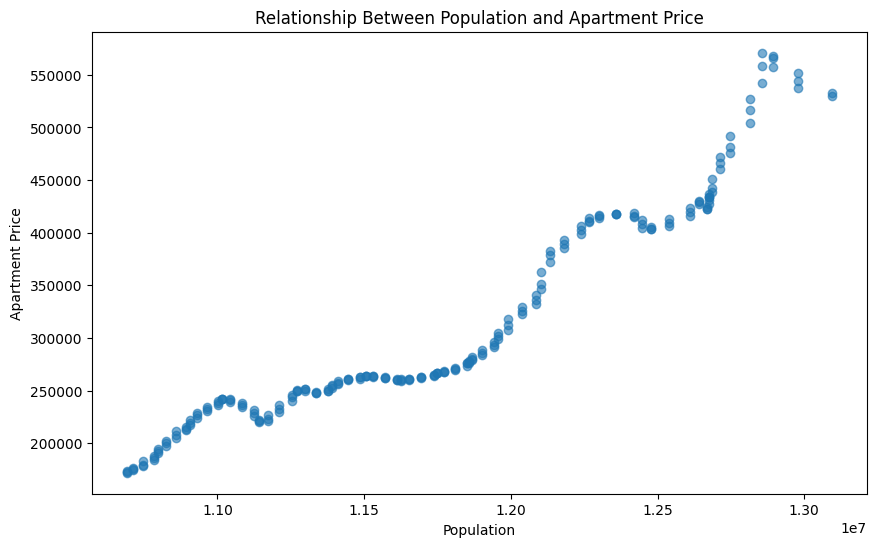

In [17]:
import matplotlib.pyplot as plt

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(data['Population'], data['Apartment_unit'], alpha=0.6)
plt.title('Relationship Between Population and Apartment Price')
plt.xlabel('Population')
plt.ylabel('Apartment Price')
plt.show()



#### Hypothesis

**Null Hypothesis (H0):**  
There is no significant correlation between population growth and housing price increases when controlling for income changes.

**Alternative Hypothesis (H1):**  
Population growth has a significant positive correlation with housing price increases, even after controlling for income changes.

In [18]:
from scipy.stats import pearsonr

# Calculate the Pearson correlation and p-value
corr, p_value = pearsonr(data['Population'], data['Apartment_unit'])

# Display the correlation and p-value
print(f"Pearson Correlation: {corr}")
print(f"P-value: {p_value}")

# Hypothesis testing
if p_value < 0.05:
    print("We reject the null hypothesis (H0) and accept the alternative hypothesis (H1).")
    print("This means there is a significant correlation between population growth and rising apartment prices.")
else:
    print("We do not have enough evidence to reject the null hypothesis (H0).")
    print("This means there is no significant correlation between population growth and rising apartment prices.")


Pearson Correlation: 0.9525904491385399
P-value: 4.874489699087367e-112
We reject the null hypothesis (H0) and accept the alternative hypothesis (H1).
This means there is a significant correlation between population growth and rising apartment prices.
